In [585]:
import networkx as nx
import osmnx as ox
import numpy as np
import warnings
import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
 
logging.basicConfig(filename = 'planner.log',
                    filemode="w",
                    level = logging.DEBUG,
                    format = '%(asctime)s:%(levelname)s:%(name)s:%(message)s')

logging.info("Start of the program")

warnings.filterwarnings('ignore')

In [586]:
tube_color_dict = {
	'Bakerloo': "#ae6118",
	'Central': "#ae6118",
	'District': "#00a575",
	'Circle': "#f8d42d",
    'DLR': "#00bbb4",
    'Hammersmith and City': "#e899a8",
	'Jubilee': "#8f989e",
	'Metropolitan': "#893267",
	'Northern': "#1C1C1C",
    'Overground': "#F86C00",
	'Piccadilly': "#0450a1",
	'Victoria': "#009fe0",
	'Waterloo and City': "#70c3ce",
    'Elizabeth': "#603E99"
}

# MAP_PATH = "./data/london.graphml"
# MAP_TUBE_PATH = "./data/london_tube.graphml"

# LONDON_NORTH, LONDON_SOUTH, LONDON_EAST, LONDON_WEST = 51.672343, 51.384940, 0.148271, -0.351468

ACCEPTABLE_WALKING_DISTANCE = 1000 # 1 km
INITIAL_WALKING_TIME = 5 * 60 # 5 minutes
ACCEPTABLE_WALKING_TIME = 20 * 60 # 20 minutes
NEARBY_STATION_NUM = 3

TRANSFERS_PENALTY = 3
COST_PENALTY = 0
WK_WEIGHT = 5

DRAW_MAP = False

WALKING_SPEED = 1.34112 # m/s
WALKING_SPEED_MALE = 1.4 # m/s
WALKING_SPEED_FEMALE = 1.31 # m/s
WALKING_SPEED_YOUNG = 1.45 # m/s
WALKING_SPEED_OLD = 1.19 # m/s

tube_speeds = [27.04, 37.29, 24.31, 29.44, 27.65, 40.32, 44.14, 34.09, 32.65, 42.49, 33.30]
TRANSPORT_SPEED =  (np.mean(tube_speeds) - 20) / 3.6 # km/h to m/s

user_group = ''

In [587]:
# origin_address = 'Finchley Road Station, London, UK'
# dest_address = 'Covent Garden, London, UK'

origin_address = 'Finchley Road Station, London, UK'
dest_address = 'Bush House, London, UK'

# origin_address = "Paddington Station, London, UK"
# dest_address = 'Bush House, London, UK'

# origin_address = "Madame Tussauds London, London, UK"
# dest_address = 'Park Royal, London, UK'

# origin_address = "Lancaster Gate, London, UK"
# dest_address = 'Natural History Museum, London, UK'

# origin_address = "Euston Station, London, UK"
# dest_address = 'Natural History Museum, London, UK'


address_compact = origin_address.split(",")[0].replace(" ", "_") + '-' + dest_address.split(",")[0].replace(" ", "_")
origin_lat, origin_lon = ox.geocode(origin_address)
dest_lat, dest_lon = ox.geocode(dest_address)

In [588]:
def get_bbox_bound_from_coord(lat1, lon1, lat2, lon2):
    north, south, east, west = -100, 100, -100, 100
    if lat1 > north: north = lat1
    if lat2 > north: north = lat2
    if lat1 < south: south = lat1
    if lat2 < south: south = lat2
    if lon1 > east: east = lon1
    if lon2 > east: east = lon2
    if lon1 < west: west = lon1
    if lon2 < west: west = lon2

    diff = 0.02
    
    return north+diff, south-diff, east+diff, west-diff

In [589]:
north, south, east, west = get_bbox_bound_from_coord(origin_lat, origin_lon, dest_lat, dest_lon)
G = ox.graph_from_bbox(north, south, east, west, network_type="walk")
# ox.save_graphml(G, MAP_PATH)

In [590]:
origin, dist1 = ox.nearest_nodes(G, origin_lon, origin_lat, return_dist=True)
dest, dist2 = ox.nearest_nodes(G, dest_lon, dest_lat, return_dist=True)

In [591]:
# add weights to walking edges based on age/gender
for u, v, k, data in G.edges(data=True, keys=True):
    # data['color'] = '#AAFF00'
    distance = data["length"]
    data["time"] = round(distance / WALKING_SPEED) * WK_WEIGHT
    # data["time_male"] = round(distance / WALKING_SPEED_MALE) * WK_WEIGHT
    # data["time_female"] = round(distance / WALKING_SPEED_FEMALE)  * WK_WEIGHT
    # data["time_young"] = round(distance / WALKING_SPEED_YOUNG) * WK_WEIGHT
    # data["time_old"] = round(distance / WALKING_SPEED_OLD) * WK_WEIGHT
    # logging.debug(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_old'], 3)} seconds (old)")
    # logging.debug(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_female'], 3)} seconds (female)")
    # logging.debug(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time'], 3)} seconds (google)")
    # logging.debug(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_male'], 3)} seconds (male)")
    # logging.debug(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_young'], 3)} seconds (young)")
    # break

G_wk = G.copy()

In [592]:
import json

with open('input/LondonTubeLines_minimal.json', 'r') as f:
    data = json.load(f)

tube_lines, route_colors = [], []
stations_osmid = set()
# Iterating through the json list
for tube_route in data['features']:
    start_end = tube_route['geometry']['coordinates']
    orig_lon, orig_lat = start_end[0][0], start_end[0][1]
    end_lon, end_lat = start_end[1][0], start_end[1][1]

    orig_node, dist1 = ox.nearest_nodes(G, orig_lon, orig_lat, return_dist=True)
    end_node, dist2 = ox.nearest_nodes(G, end_lon, end_lat, return_dist=True)

    # ignore stations and routes that are not within 50m of the graph
    if dist1 > 50 or dist2 > 50:
        continue

    stations_osmid.add(orig_node)
    stations_osmid.add(end_node)

    line_color = tube_route['properties']['stroke']
    feature_str = tube_route['properties']['name'].split(' - ')
    line_name = feature_str[0]
    # start_station_name = feature_str[1].split(' to ')[0].split(' (')[0]
    # end_station_name = feature_str[1].split(' to ')[1].split(' (')[0]
    start_station_name = feature_str[1].split(' to ')[0]
    end_station_name = feature_str[1].split(' to ')[1]

    # add line info to start station
    G.nodes[orig_node]['station_name'] = start_station_name

    try: 
        G.nodes[orig_node]['lines_name'].add(line_name)
    except (KeyError, AttributeError) as e:
        G.nodes[orig_node]['lines_name'] = {line_name}
    
    # add line info to end station
    G.nodes[end_node]['station_name'] = end_station_name

    try: 
        G.nodes[end_node]['lines_name'].add(line_name)
    except (KeyError, AttributeError) as e:
        G.nodes[end_node]['lines_name'] = {line_name}

    logging.debug(f"{G.nodes[orig_node]['station_name']}: {G.nodes[orig_node]['lines_name']}")
    logging.debug(f"{G.nodes[end_node]['station_name']}: {G.nodes[end_node]['lines_name']}")

    G.add_edge(orig_node, end_node, color=tube_route['properties']['stroke'])
    G.add_edge(end_node, orig_node, color=tube_route['properties']['stroke'])
    
    tube_lines.append(nx.shortest_path(G, orig_node, end_node))
    route_colors.append(tube_route['properties']['stroke'])

logging.debug(f"all station info been added\n")
ox.distance.add_edge_lengths(G)

In [593]:
# add weight to tp edges
for u, v, k, data in G.edges(data=True, keys=True):
    if 'time' not in data:
        data['travel_mode'] = 'tp'
        data["time"] = round(data["length"] / TRANSPORT_SPEED, 2)
        logging.debug(f"add tp time{data}")
        # data["time"] = data["time_male"] = data["time_female"] = data["time_young"] = data["time_old"] = data["length"] / TRANSPORT_SPEED
        # data["time_fake"] = data["length"] / TRANSPORT_SPEED_FAKE
        # print(f"distance: {round(data['length'], 3)} m \ttp time: {round(data['time'], 3)} seconds")

In [594]:
# plot london tube maps on top of walking map
if DRAW_MAP:
    fig, ax = ox.plot_graph_routes(G, tube_lines, route_linewidths=2, route_colors=route_colors, route_alpha=.8, \
                                node_color='w', node_size=.2, orig_dest_size=30, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, \
                                dpi=300)

    fig.savefig(f"output/tube_map_{address_compact}.png", dpi=300, bbox_inches='tight')

In [595]:
def get_transfers_nums(G, route):
    last_travel_mode = 'walk'
    transfer = 0
    for i in range(len(route)-1):
        start_node, end_node = route[i], route[i+1]
        if 'lines_name' in G.nodes[start_node] and 'lines_name' in G.nodes[end_node]:
            tube_line = set.intersection(G.nodes[start_node]['lines_name'], G.nodes[end_node]['lines_name']).pop()
            travel_mode = tube_line
        else:
            travel_mode = 'walk'
        
        if last_travel_mode != travel_mode:
            transfer += 1

        last_travel_mode = travel_mode
    
    return transfer

In [596]:
def get_total_wk_time(G, route):
    total_wk_time = 0
    for i in range(len(route)-1):
        start_node, end_node = route[i], route[i+1]
        if 'lines_name' in G.nodes[start_node] and 'lines_name' in G.nodes[end_node]:
            continue
        else:
            total_wk_time += nx.shortest_path_length(G, start_node, end_node, weight='time')
    return total_wk_time

In [597]:
def get_route_description(G, route, route_chunks=[], route_colors=[], debug=True, total_wk_time=0, total_tp_time=0, transfer=0):
    if debug:
        logging.debug(f"Start at : {origin_address}")
    else:
        print(f"Start at : {origin_address}")

    last_travel_mode = 'walk'
    last_station = ''

    for i in range(len(route)-1):
        start_node, end_node = route[i], route[i+1]
        route_chunks.append([start_node, end_node])
        if 'lines_name' in G.nodes[start_node] and 'lines_name' in G.nodes[end_node]:
            # logging.debug(f"start_station: {G.nodes[start_node]['lines_name']}")
            # logging.debug(f"end_station: {G.nodes[end_node]['lines_name']}")
            tube_line_choices = set.intersection(G.nodes[start_node]['lines_name'], G.nodes[end_node]['lines_name'])
            # logging.debug(f"intersections: {tube_line_choices}")
            
            # choose a line that causes least transfer
            j = i + 1
            while len(tube_line_choices) > 1 and j < len(route)-1 and 'lines_name' in G.nodes[route[j]]:
                if len(set.intersection(tube_line_choices, G.nodes[route[j]]['lines_name'])) > 0:
                    tube_line_choices = set.intersection(tube_line_choices, G.nodes[route[j]]['lines_name'])
                else:
                    break
                j += 1
            tube_line = tube_line_choices.pop()
            # logging.debug(f"choice: {tube_line}")
            route_colors.append(tube_color_dict[tube_line])
            
            if last_travel_mode != 'walk' and last_travel_mode != tube_line:
                if debug:
                    logging.debug(f"   -> to [{last_station}]")
                else:
                    print(f"   -> to [{last_station}]")
            last_station = G.nodes[end_node]['station_name']
            travel_mode = tube_line
            # record tp time
            total_tp_time += G.edges[start_node, end_node, 0]["time" + user_group]
        else:
            travel_mode = 'walk'
            route_colors.append('springgreen')
            # record wk time
            total_wk_time += G.edges[start_node, end_node, 0]["time" + user_group]
        
        if last_travel_mode != travel_mode:
            transfer += 1
            if last_travel_mode == 'walk':
                if debug:
                    logging.debug(f"{transfer}. 🚄 From [{G.nodes[start_node]['station_name']}] take {tube_line} line")
                else:
                    print(f"{transfer}. 🚄 From [{G.nodes[start_node]['station_name']}] take {tube_line} line")
            elif travel_mode == 'walk':
                if last_station != '':
                    if debug:
                        logging.debug(f'   -> Get off at [{last_station}]')
                    else:
                        print(f'   -> Get off at [{last_station}]')
                if debug:
                    logging.debug(f'{transfer}. 🚶🏻 Walk')
                else:
                    print(f'{transfer}. 🚶🏻 Walk')
            else:
                if debug:
                    logging.debug(f"{transfer}. 🚄 Change at [{G.nodes[start_node]['station_name']}] to {tube_line} line")
                else:
                    print(f"{transfer}. 🚄 Change at [{G.nodes[start_node]['station_name']}] to {tube_line} line")

        last_travel_mode = travel_mode

    total_wk_time = round(total_wk_time/WK_WEIGHT/60, 2)
    total_tp_time = round(total_tp_time/60, 2)

    if debug:
        logging.debug(f"Reaching destination: {dest_address}\n")
        logging.debug(f"Transfers: {transfer} times")
        logging.debug(f"Total wk time: {total_wk_time} minutes")
        logging.debug(f"Total tp time: {total_tp_time} minutes")
    else: 
        print(f"Reaching destination: {dest_address}\n")
        print(f"Transfers: {transfer} times")
        print(f"Total wk time: {total_wk_time} minutes")
        print(f"Total tp time: {total_tp_time} minutes")

    return total_wk_time, total_tp_time, transfer

In [598]:
def get_bbox_bound(node_list):
    north, south, east, west = -100, 100, -100, 100
    for node in node_list:
        if G.nodes[node]['y'] > north:
            north = G.nodes[node]['y']
        if G.nodes[node]['y'] < south:
            south = G.nodes[node]['y']
        if G.nodes[node]['x'] > east:
            east = G.nodes[node]['x']
        if G.nodes[node]['x'] < west:
            west = G.nodes[node]['x']
    diff_h = 0.01
    diff_v = 0.01
    return north+diff_h, south-diff_h, east+diff_v, west-diff_v


Nearby station to Finchley Road Station, London, UK: 
West Hampstead, Finchley Road, Swiss Cottage
Nearby station to Bush House, London, UK: 
Temple, Blackfriars, Embankment

👍🏻 Final Choice:
Start at : Finchley Road Station, London, UK
1. 🚄 From [Finchley Road] take Jubilee line
   -> to [Bond Street]
2. 🚄 Change at [Bond Street] to Central line
   -> to [Oxford Circus]
3. 🚄 Change at [Oxford Circus] to Bakerloo line
   -> to [Embankment]
4. 🚄 Change at [Embankment] to District line
   -> Get off at [Temple]
5. 🚶🏻 Walk
Reaching destination: Bush House, London, UK

Transfers: 5 times
Total wk time: 6.57 minutes
Total tp time: 18.17 minutes
Total Trip time: 24.740000000000002 minutes




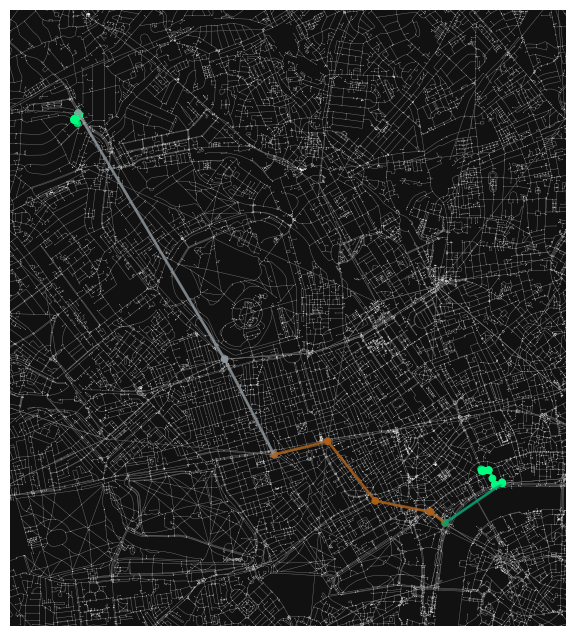

In [599]:
# user_group = '_old'
# user_group = '_young'
# user_group = ''

# find stations that are within AWD of the origin and destination
stations_near_origin, stations_near_dest = [], []
awt_origin = awt_dest = INITIAL_WALKING_TIME
while len(stations_near_origin) < NEARBY_STATION_NUM or len(stations_near_dest) < NEARBY_STATION_NUM:
    stations_near_origin, stations_near_dest = [], []
    for station in stations_osmid:
        if nx.shortest_path_length(G, origin, station, weight="time" + user_group) < awt_origin:
            stations_near_origin.append(station)
        if nx.shortest_path_length(G, dest, station, weight="time" + user_group) < awt_dest:
            stations_near_dest.append(station)

    # testing
    logging.debug(f"AWT_ORIGIN: {awt_origin/60} minutes")
    logging.debug(f"AWT_DEST: {awt_dest/60} minutes\n")

    if len(stations_near_origin) < NEARBY_STATION_NUM:
        awt_origin += (2 * 60)
    if len(stations_near_dest) < NEARBY_STATION_NUM:
        awt_dest += (2 * 60)

    # if awt_origin >= ACCEPTABLE_WALKING_TIME or awt_dest >= ACCEPTABLE_WALKING_TIME:
    #     break

print(f'Nearby station to {origin_address}: ')
print(*(G.nodes[s]['station_name'] for s in stations_near_origin), sep=', ')
print(f'Nearby station to {dest_address}: ')
print(*(G.nodes[s]['station_name'] for s in stations_near_dest), sep=', ')
print('')

route_weight_dict = {}
route_chunks, route_chunk_colors = [], []

search_route_num = 0

for station_dest in stations_near_dest:
    for station_origin in stations_near_origin:
        search_route_num += 1
        logging.debug(f"Searching route {search_route_num} from {G.nodes[station_origin]['station_name']} to {G.nodes[station_dest]['station_name']}")
        origin_to_station = nx.shortest_path(G, origin, station_origin, weight="time" + user_group)
        tp_routes = [p for p in nx.all_shortest_paths(G, station_origin, station_dest, weight="time" + user_group)]
        # tp_route = nx.shortest_path(G, station_origin, station_dest, weight="time" + user_group)
        station_to_dest = nx.shortest_path(G, station_dest, dest, weight="time" + user_group)
        logging.debug(f"all shortest paths: {len(tp_routes)}\n")
        for tp_route in tp_routes:
            route = origin_to_station[:-1] + tp_route + station_to_dest[1:]
            total_wk_time, total_tp_time, transfer = get_route_description(G, route)
            trip_time = total_wk_time + total_tp_time
            logging.debug(f"Total Trip time: {trip_time} minutes")
            final_weight = trip_time + (transfer * TRANSFERS_PENALTY)
            logging.debug(f"Final weight: {final_weight} \n\n")
            
            route_weight_dict[final_weight] = route, trip_time
logging.debug(f"Total number of routes searched: {search_route_num}\n\n")

# make the final choice
route_chunks, route_chunk_colors = [], []
best_route, trip_time = route_weight_dict[min(route_weight_dict.keys())]
print("👍🏻 Final Choice:")
get_route_description(G, best_route, route_chunks, route_chunk_colors, debug=False)
print(f"Total Trip time: {trip_time} minutes\n\n")

# draw the best route
north, south, east, west = get_bbox_bound(best_route)

fig, ax = ox.plot_graph_routes(G, route_chunks, route_linewidths=2, route_colors=route_chunk_colors, route_alpha=.8, \
                            node_color='w', node_size=.2, orig_dest_size=30, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, \
                            bbox=(north, south, east, west), dpi=300) 

fig.savefig(f"output/plan{user_group}_{address_compact}.png", dpi=300, bbox_inches='tight')

In [600]:
# total_time = nx.dijkstra_path_length(G, origin, dest, weight="time")
# print(f"Total time: {round(total_time/60, 3)} minutes")
# total_time = nx.dijkstra_path_length(G, origin, dest, weight="time_old")
# print(f"Total time: {round(total_time/60, 3)} minutes (old)")
# total_time = nx.dijkstra_path_length(G, origin, dest, weight="time_female")
# print(f"Total time: {round(total_time/60, 3)} minutes (female)")
# total_time = nx.dijkstra_path_length(G, origin, dest, weight="time_male")
# print(f"Total time: {round(total_time/60, 3)} minutes (male)")
# total_time = nx.dijkstra_path_length(G, origin, dest, weight="time_young")
# print(f"Total time: {round(total_time/60, 3)} minutes (young)")